In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
from utils import plot, rolling_sharpe, plot_rolling_sharpe, plot_rolling_vol
%matplotlib inline

In [2]:
cash = 80000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2021-03-16_17-11_20180601_20191231_base_adjusted.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
micro_contracts = df[df.contract.str.startswith('M')]
macro_contracts = df[~df.contract.str.startswith('M')]
micro_contracts['amount'] /= 10
df = pd.concat([macro_contracts, micro_contracts]).sort_index()
df.contract = df.contract.str.strip('M')
df['contract'] = df['contract'].apply(lambda x: x[:2])
df.contract = df.contract.str.strip()

In [4]:
pnl = df.groupby('contract').realizedPNL.sum()
pnl['total'] = pnl.sum()
pnl

contract
ES       408928.45
NQ       287282.34
YM       285464.00
total    981674.79
Name: realizedPNL, dtype: float64

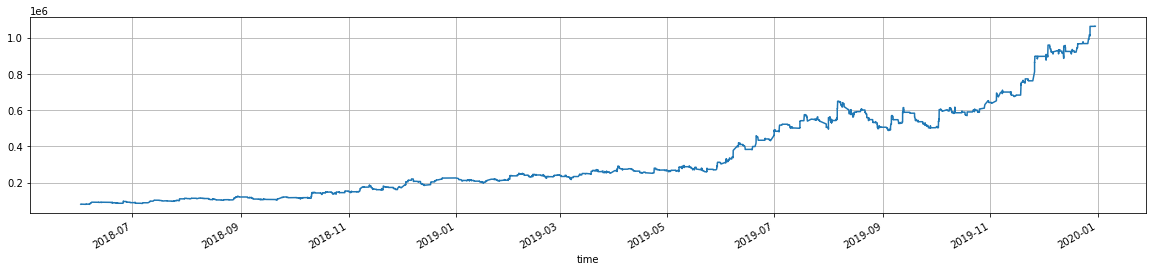

In [5]:
df.cash.plot(figsize=(20,4), grid=True);

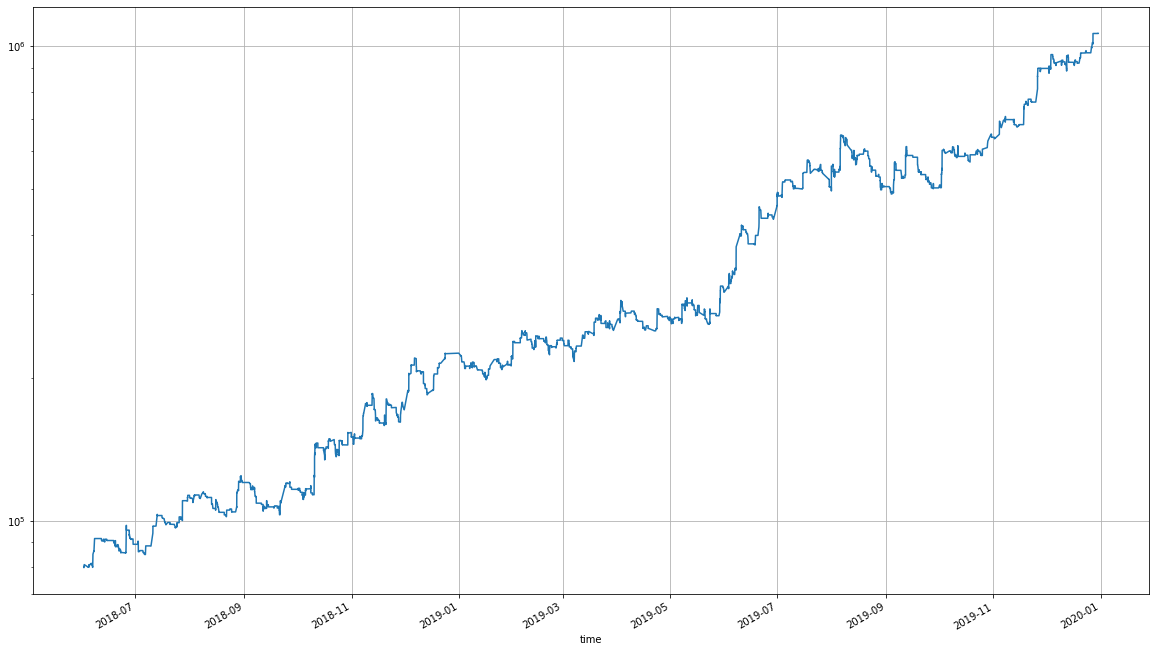

In [6]:
df.cash.plot(figsize=(20,12), grid=True, logy=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, aggfunc='sum', columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
#monthly average number of transactions
daily_count = df.groupby('contract').action.resample('B').count()
zero_index = set(daily_count.index.get_level_values(0))
monthly_count = daily_count.groupby('contract').resample('M', level=1).mean()
average_monthly_contracts = pd.DataFrame({contract: monthly_count[contract] for contract in zero_index})
average_monthly_contracts

,YM,ES,NQ
time,,,
2018-06-30,2.000000,0.761905,7.904762
2018-07-31,1.181818,0.772727,4.818182
2018-08-31,1.478261,0.391304,5.913043
2018-09-30,1.100000,0.700000,6.700000
2018-10-31,3.130435,1.652174,10.173913
2018-11-30,2.727273,1.272727,9.909091
2018-12-31,2.571429,1.047619,2.952381
2019-01-31,2.000000,0.956522,6.434783
2019-02-28,1.600000,0.500000,6.500000


In [9]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     398
 NQ    3128
 YM     818
 Name: action, dtype: int64,
 4344)

In [10]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.966019
 NQ    7.592233
 YM    1.985437
 Name: action, dtype: float64,
 10.54368932038835)

In [11]:
# commission paid
comm = df.groupby('contract').commission.sum()
comm['total'] = comm.sum()
comm

contract
ES        5645.30
NQ       41824.66
YM       11937.00
total    59406.96
Name: commission, dtype: float64

In [12]:
# commission paid as percent of pnl
round((comm/pnl) *100, 1)

contract
ES        1.4
NQ       14.6
YM        4.2
total     6.1
dtype: float64

In [13]:
# per trade stats (pro rated per macro contract)
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss', 
                                'win_ratio', 'EV/contract', 'number_of_contracts'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    d['pnl_per_contract'] = d.realizedPNL / d.amount
    row['average_PNL'] = round(d['pnl_per_contract'].mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0])['pnl_per_contract'].mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0])['pnl_per_contract'].mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV/contract'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_contracts'] = d.amount.sum()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV/contract,number_of_contracts
NQ,0.39,19.88,422.84,-239.16,1.77,19.02,9539.9
YM,0.44,136.52,789.90,-371.99,2.12,139.24,2727.0
ES,0.51,282.99,1074.20,-532.43,2.02,286.95,1291.5
total,0.41,65.95,570.25,-285.48,2.00,65.37,13558.4


In [14]:
edge = results['win_ratio'] - ((1-results['success_rate'])/ results['success_rate'])
edge

NQ       0.205897
YM       0.847273
ES       1.059216
total    0.560976
dtype: float64

In [15]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
daily_scaled

contract,ES,NQ,YM,total
time,,,,
2018-06-01,0.00,2378.34,0.00,792.78
2018-06-04,0.00,-20.58,0.00,-6.86
2018-06-05,0.00,996.48,300.24,432.24
2018-06-06,15793.74,-1630.26,-2871.18,3764.10
2018-06-07,0.00,4265.28,15789.60,6684.96
...,...,...,...,...
2019-12-24,0.00,0.00,0.00,0.00
2019-12-25,0.00,0.00,0.00,0.00
2019-12-26,0.00,68262.84,0.00,22754.28


In [16]:
returns = daily.divide(total_cumsum, axis=0)
returns

contract,ES,NQ,YM,total
time,,,,
2018-06-01,0.00000,0.009910,0.000000,0.009910
2018-06-04,0.00000,-0.000085,0.000000,-0.000085
2018-06-05,0.00000,0.004112,0.001239,0.005350
2018-06-06,0.06482,-0.006691,-0.011784,0.046346
2018-06-07,0.00000,0.016730,0.061933,0.078663
...,...,...,...,...
2019-12-24,0.00000,0.000000,0.000000,0.000000
2019-12-25,0.00000,0.000000,0.000000,0.000000
2019-12-26,0.00000,0.023541,0.000000,0.023541


In [17]:
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)

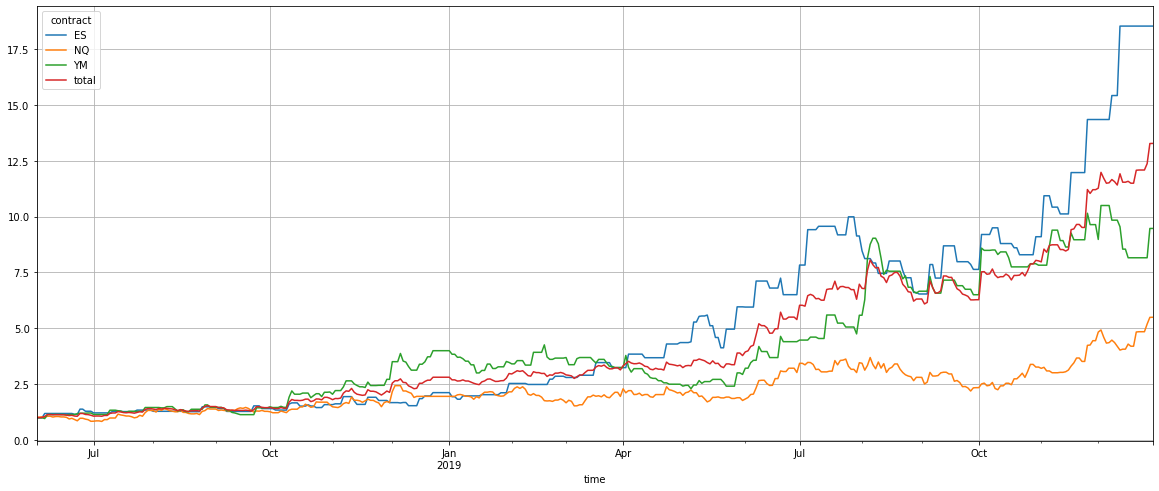

In [18]:
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,NQ,YM,total
contract,,,,
ES,1.000000,0.208425,0.245404,0.678571
NQ,0.208425,1.000000,0.262657,0.697574
YM,0.245404,0.262657,1.000000,0.728213
total,0.678571,0.697574,0.728213,1.000000


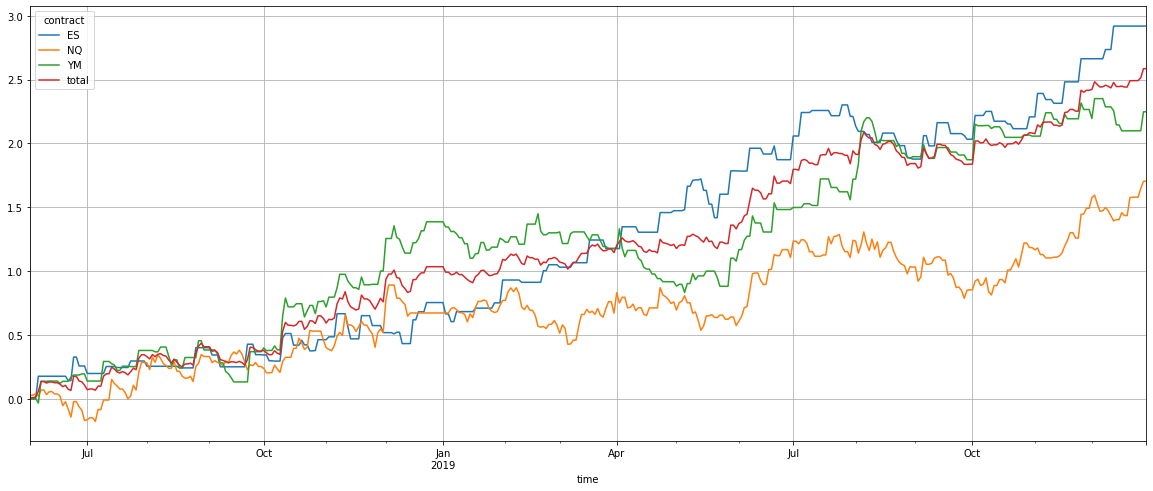

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

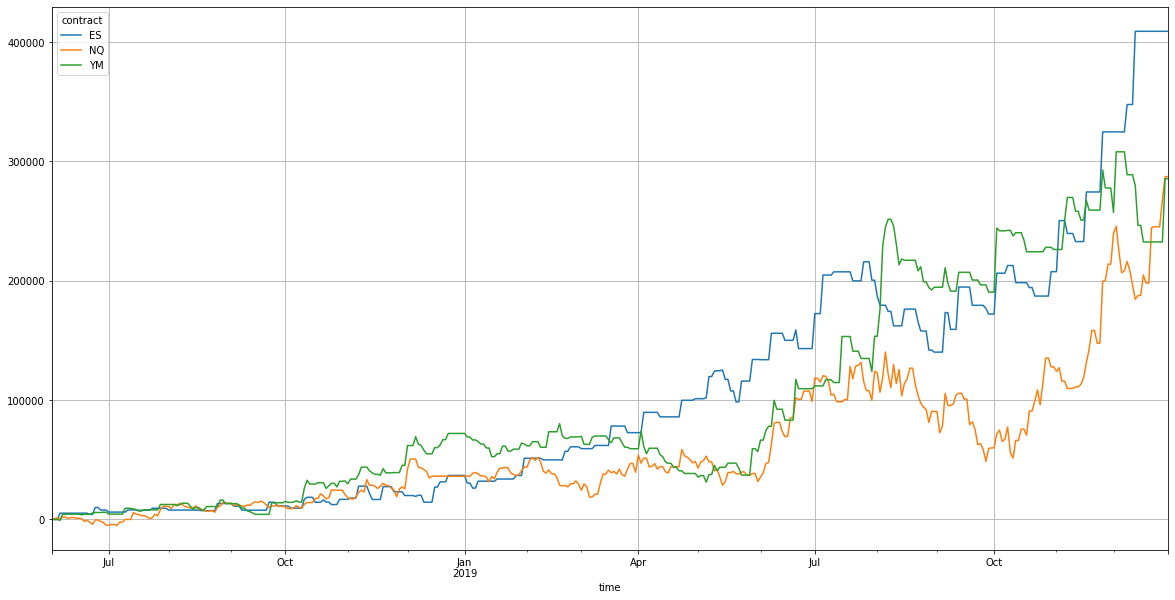

In [21]:
# dollar returns cummulative
by_contract.resample('B').sum().drop('total', axis=1).cumsum().plot(figsize=(20,10), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,NQ,YM,total
Annual return,4.961237,1.835994,2.955076,3.862093
Cumulative returns,17.518827,4.497145,8.468929,12.270935
Annual volatility,0.860442,0.871431,0.932608,0.627471
Sharpe ratio,2.477604,1.617287,1.905037,2.825015
Calmar ratio,14.357877,4.529201,6.420133,15.832484
Stability,0.952120,0.856216,0.890172,0.974665
Max drawdown,-0.345541,-0.405368,-0.460283,-0.243935
Omega ratio,2.280215,1.351971,1.649990,1.801445
Sortino ratio,6.274997,2.928336,4.387132,6.849155
Skew,2.300514,1.050278,2.372075,1.943989


In [23]:
#non-scaled returns
stats_non_scaled = pd.DataFrame()
for col in daily.columns:
    stats_non_scaled[col] = perf_stats(returns[col])
stats_non_scaled

,ES,NQ,YM,total
Annual return,0.953997,0.534058,0.724483,3.862093
Cumulative returns,1.989767,1.012966,1.437354,12.270935
Annual volatility,0.286814,0.290477,0.310869,0.627471
Sharpe ratio,2.477604,1.617287,1.905037,2.825015
Calmar ratio,7.450662,3.643413,4.124776,15.832484
Stability,0.959592,0.909427,0.915024,0.974665
Max drawdown,-0.128042,-0.146582,-0.175642,-0.243935
Omega ratio,2.280215,1.351971,1.649990,1.801445
Sortino ratio,6.274997,2.928336,4.387132,6.849155
Skew,2.300514,1.050278,2.372075,1.943989


In [24]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,NQ,YM,total
time,,,,
2018-06-30,9.86,-5.01,7.13,11.44
2018-07-31,1.41,17.44,6.87,26.81
2018-08-31,3.86,2.11,0.64,6.42
2018-09-30,-1.26,-2.32,0.33,-3.26
2018-10-31,4.66,7.71,15.87,28.98
2018-11-30,2.94,2.95,8.73,14.00
2018-12-31,8.80,6.41,15.08,31.63
2019-01-31,6.68,3.63,-4.17,5.85
2019-02-28,4.20,-5.86,2.46,0.44


In [25]:
monthly_returns.total.mean(), monthly_returns.total.median()

(15.50263157894737, 12.839999999999998)

In [26]:
monthly_returns.sort_values('total', ascending = False).total

time
2019-06-30    42.55
2019-11-30    39.69
2018-12-31    31.63
2019-07-31    29.33
2018-10-31    28.98
2019-10-31    27.68
2018-07-31    26.81
2019-12-31    18.46
2018-11-30    14.00
2019-05-31    12.84
2018-06-30    11.44
2019-04-30     6.66
2018-08-31     6.42
2019-01-31     5.85
2019-03-31     5.04
2019-02-28     0.44
2019-09-30    -0.53
2018-09-30    -3.26
2019-08-31    -9.48
Name: total, dtype: float64

In [27]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        199.0
NQ        101.0
YM        144.0
total    1227.0
dtype: float64

In [28]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-12-12 16:03:30,ES,SELL,3171.25,60302.8
2019-08-05 21:19:30,YM,BUY,25629.00,53053.6
2019-12-27 15:58:00,YM,SELL,28621.00,52175.2
2019-10-02 20:46:00,YM,BUY,26070.00,51268.6
2019-11-26 02:50:30,NQ,SELL,8405.25,50702.4
...,...,...,...,...
2019-08-28 16:42:00,ES,BUY,2877.50,-15983.8
2019-12-09 18:23:00,YM,SELL,27944.00,-19100.6
2019-12-02 14:15:30,YM,SELL,28099.00,-20433.2


In [29]:
daily.sort_values('total', ascending=False)

contract,ES,NQ,YM,total
time,,,,
2019-11-26,50308.75,51785.76,33542.32,135636.83
2019-10-02,34242.96,11818.72,53677.08,99738.76
2019-09-05,33105.25,27400.42,16347.88,76853.55
2019-12-27,0.00,19077.38,53001.62,72079.00
2019-11-18,41560.86,12842.58,16448.56,70852.00
...,...,...,...,...
2019-07-19,-7584.20,-10236.28,-12270.64,-30091.12
2019-12-13,0.00,3181.90,-33374.56,-30192.66
2019-08-12,0.00,-15997.70,-14981.44,-30979.14


In [30]:
# gaining vs. losing days in percent
results_dict = {}
_daily = daily[daily['total'] != 0]
for c in _daily.columns:
    gain = _daily[_daily[c]>0][c].count()
    loss = _daily[_daily[c]<0][c].count()
    total = _daily[_daily[c]!=0][c].count()
    results_dict[c] = {'gain': round(gain/total,2), 
                       'loss': round(loss/total,2), 
                       }
frequency = pd.DataFrame(results_dict)
frequency

,ES,NQ,YM,total
gain,0.5,0.5,0.46,0.49
loss,0.5,0.5,0.54,0.51


In [31]:
# daily gain/loss ratio
results = {}
for c in _daily.columns:
    gain = _daily[_daily[c]>0][c]
    loss = -_daily[_daily[c]<0][c]
    results[c] = round(gain.mean()/loss.mean(),2)
ratios = pd.Series(results)
ratios

ES       2.37
NQ       1.41
YM       1.82
total    1.91
dtype: float64

In [32]:
# daily EV in stop-loss units
r = {}
for i in ratios.iteritems():
    r[i[0]] = frequency[i[0]].gain * i[1] - frequency[i[0]].loss
ev = pd.Series(r)
ev

ES       0.6850
NQ       0.2050
YM       0.2972
total    0.4259
dtype: float64

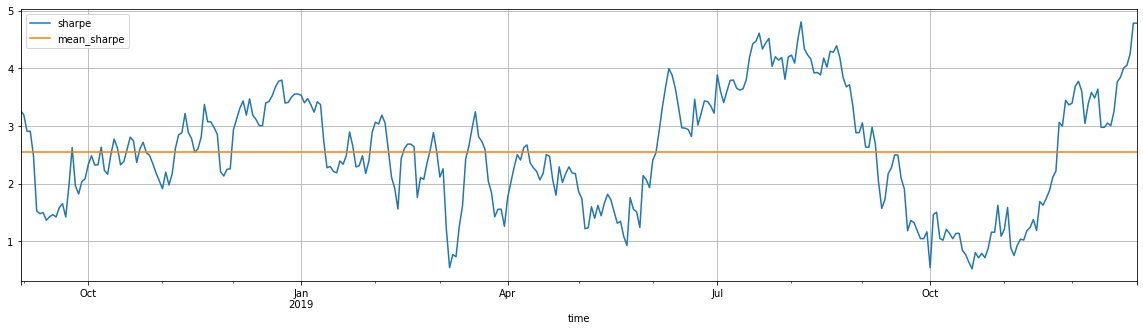

In [33]:
plot_rolling_sharpe(returns.total, 3)

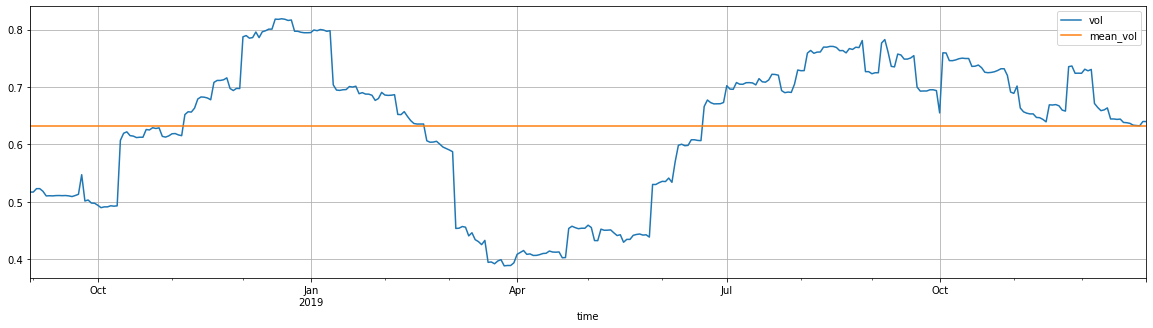

In [34]:
plot_rolling_vol(returns.total, 3)